# Introduction to machine learning & Data Analysis

Basic introduction on how to perform typical machine learning tasks with Python.

Prepared by Mykhailo Vladymyrov & Aris Marcolongo,
Science IT Support, University Of Bern, 2021

This work is licensed under <a href="https://creativecommons.org/share-your-work/public-domain/cc0/">CC0</a>.

# Part 3.

# Load libraries

In [ ]:
from sklearn import tree
from sklearn import ensemble

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from matplotlib import  pyplot as plt
import seaborn as sns
#sns.set()

from time import time as timer
from imageio import imread
import pandas as pd
import numpy as np
import os

from sklearn.manifold import TSNE

import tensorflow as tf
import tarfile

%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

In [ ]:
pip install umap-learn

     |████████████████████████████████| 86 kB 3.3 MB/s 
     |████████████████████████████████| 1.1 MB 18.3 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=f9b0a389c5f57dd49bd53439c48bddaaa0376214073e0977433cf7cf394c4be5
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=92af97c342041a5369781df6b5ec8c020db18533faa48af964590eee9a66bfa9
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


In [ ]:
import umap

In [ ]:
if not os.path.exists('data'):
    path = os.path.abspath('.')+'/colab_material.tgz'
    tf.keras.utils.get_file(path, 'https://github.com/neworldemancer/DSF5/raw/master/colab_material.tgz')
    tar = tarfile.open(path, "r:gz")
    tar.extractall()
    tar.close()

196608/184367 [===============================] - 0s 0us/step


In [ ]:
from utils.routines import *

# Datasets

In this course we will use several synthetic and real-world datasets to illustrate the behavior of the models and exercise our skills.

## 1. Synthetic linear

In [ ]:
def get_linear(n_d=1, n_points=10, w=None, b=None, sigma=5):
  x = np.random.uniform(0, 10, size=(n_points, n_d))
  
  w = w or np.random.uniform(0.1, 10, n_d)
  b = b or np.random.uniform(-10, 10)
  y = np.dot(x, w) + b + np.random.normal(0, sigma, size=n_points)

  print('true slopes: w =', w, ';  b =', b)

  return x, y

true slopes: w = [2.98835701] ;  b = 9.762607136761495


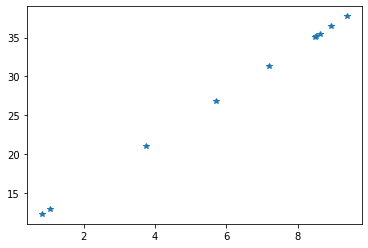

In [ ]:
x, y = get_linear(n_d=1, sigma=0)
plt.plot(x[:, 0], y, '*')
plt.show()

true slopes: w = [1.34322236 8.19635997] ;  b = 9.00807584837873


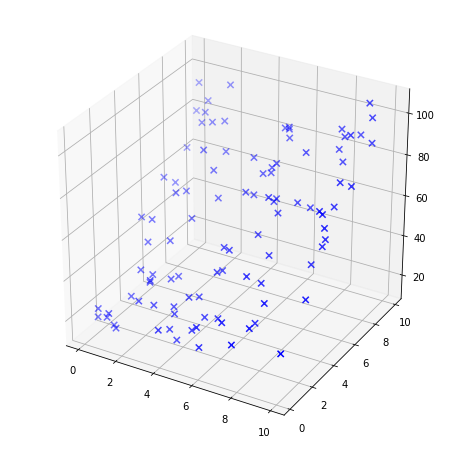

In [ ]:
n_d = 2
x, y = get_linear(n_d=n_d, n_points=100)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0], x[:,1], y, marker='x', color='b',s=40)
plt.show()

## 2. House prices

Subset of the Ames Houses dataset: http://jse.amstat.org/v19n3/decock.pdf

In [ ]:
def house_prices_dataset(return_df=False, price_max=400000, area_max=40000):
  path = 'data/AmesHousing.csv'

  df = pd.read_csv(path, na_values=('NaN', ''), keep_default_na=False)
  
  rename_dict = {k:k.replace(' ', '').replace('/', '') for k in df.keys()}
  df.rename(columns=rename_dict, inplace=True)
  
  useful_fields = ['LotArea',
                  'Utilities', 'OverallQual', 'OverallCond',
                  'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond',
                  'HeatingQC', 'CentralAir', 'Electrical',
                  '1stFlrSF', '2ndFlrSF','GrLivArea',
                  'FullBath', 'HalfBath',
                  'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
                  'Functional','PoolArea',
                  'YrSold', 'MoSold'
                  ]
  target_field = 'SalePrice'

  df.dropna(axis=0, subset=useful_fields+[target_field], inplace=True)

  cleanup_nums = {'Street':      {'Grvl': 0, 'Pave': 1},
                  'LotFrontage': {'NA':0},
                  'Alley':       {'NA':0, 'Grvl': 1, 'Pave': 2},
                  'LotShape':    {'IR3':0, 'IR2': 1, 'IR1': 2, 'Reg':3},
                  'Utilities':   {'ELO':0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3},
                  'LandSlope':   {'Sev':0, 'Mod': 1, 'Gtl': 3},
                  'ExterQual':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'ExterCond':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'BsmtQual':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtCond':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtExposure':{'NA':0, 'No':1, 'Mn': 2, 'Av': 3, 'Gd': 4},
                  'BsmtFinType1':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'BsmtFinType2':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'HeatingQC':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'CentralAir':  {'N':0, 'Y': 1},
                  'Electrical':  {'':0, 'NA':0, 'Mix':1, 'FuseP':2, 'FuseF': 3, 'FuseA': 4, 'SBrkr': 5},
                  'KitchenQual': {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Functional':  {'Sal':0, 'Sev':1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2':5, 'Min1':6, 'Typ':7},
                  'FireplaceQu': {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'PoolQC':      {'NA':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Fence':       {'NA':0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv':4},
                  }

  df_X = df[useful_fields].copy()                              
  df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical
  df_Y = df[target_field].copy()

  x = df_X.to_numpy().astype(np.float32)
  y = df_Y.to_numpy().astype(np.float32)

  if price_max>0:
    idxs = y<price_max
    x = x[idxs]
    y = y[idxs]

  if area_max>0:
    idxs = x[:,0]<area_max
    x = x[idxs]
    y = y[idxs]

  return (x, y, df) if return_df else (x,y)

In [ ]:
def house_prices_dataset_normed():
    x, y = house_prices_dataset(return_df=False, price_max=-1, area_max=-1)
    
    scaler=StandardScaler()
    features_scaled=scaler.fit_transform(x)
    
    return features_scaled

In [ ]:
x, y, df = house_prices_dataset(return_df=True)
print(x.shape, y.shape)
df.head()

(2847, 24) (2847,)


,Order,PID,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,...,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NA,NA,NA,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,...,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NA,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NA,MnPrv,NA,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,...,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NA,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NA,NA,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,...,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NA,NA,NA,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,...,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NA,MnPrv,NA,0,3,2010,WD,Normal,189900


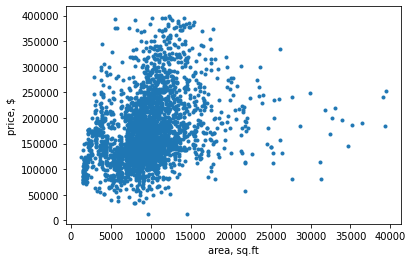

In [ ]:
plt.plot(x[:, 0], y, '.')
plt.xlabel('area, sq.ft')
plt.ylabel('price, $');
plt.show()

## 3. Blobs

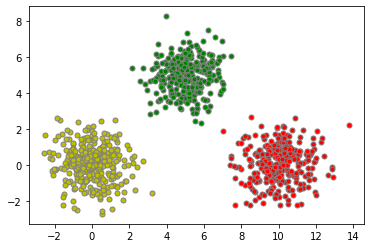

In [ ]:
x, y = make_blobs(n_samples=1000, centers=[[0,0], [5,5], [10, 0]])
colors = "ygr"
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(x[idx, 0], x[idx, 1], c=color, edgecolor='gray', s=25)
plt.show()

## 4. MNIST

The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.
It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting (taken from http://yann.lecun.com/exdb/mnist/). Each example is a 28x28 grayscale image and the dataset can be readily downloaded from Tensorflow.

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


Let's check few samples:

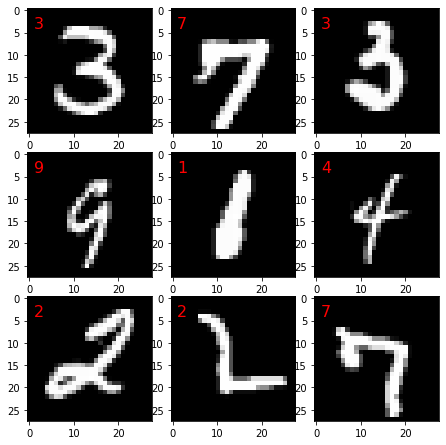

In [ ]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
  axi.grid(False)
plt.tight_layout(0,0,0)
plt.show()

## 5. Fashion MNIST

`Fashion-MNIST` is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. (from https://github.com/zalandoresearch/fashion-mnist)

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


Let's check few samples:

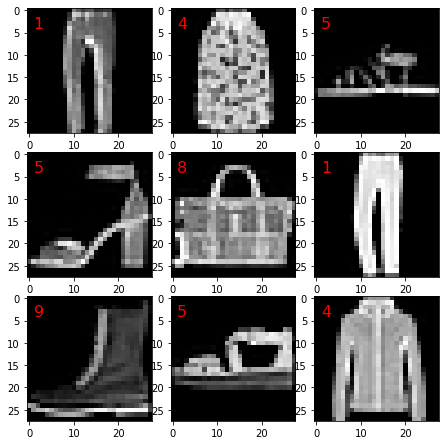

In [ ]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
  axi.grid(False)
plt.tight_layout(0,0,0)
plt.show()

Each of the training and test examples is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

In this course we will use several synthetic and real-world datasets to illustrate the behavior of the models and exercise our skills.

# 1. Unsupervised Learning Techniques


## 1. Principal Component Analysis (PCA)

### Theory overview.

**Objective:** PCA is used for dimensionality reduction when we have a large number $D$ of features with non-trivial intercorrelation ( data redundancy ) and to isolate relevant features.

PCA provides a new set of $M$ uncorrelated features for every data point, with $M \le D$. The new features are:

- a linear combination of the original ones ; 
- uncorrelated between each other ; 

If $M \ll D$ we get an effective dimensionality reduction.

**Methods:** Each data point indexed by $p=1..N$ can be seen as an element $\mathbf{x}_p \in \mathbf{R}^D$. 

The variance of the data-cloud measures the spread around its centroid:

$$S^2=\frac{1}{N}\sum_{p=1}^{N}  ( \mathbf{x}_p - \mathbf{\overline{x}})^2$$
$$\mathbf{\overline{x}}=\frac{1}{N}\sum_{p=1}^{N} \mathbf{x}_p$$

We fix a number $1\le k \le D$ and consider a subspace $V_k$ of dimension $k$. Each data point  $\mathbf{x}_p$ is projected onto $V_k$, leading to points $\mathbf{x}^k_p$ with spread $S^{2,k}$.  PCA chooses $V_k$ such that the variance $S^{2,k}$ is maximized, as shown in the picture.

<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/pca-theory.png" width="100%"/>

**Terminology and output of a PCA computation:** 
- `Principal components`: A sequence of orthonormal vectors $k_1,..,k_n$ spanning optimal subspaces: $\text{Span}\{k_1,..,k_m\}=V_m$ ; 
- `Scores`: For every sample-point $p$. the new features are called scores are given by the component of $p$ along the $k$ vectors;  
- `Reconstructed vector`: For every $k$, the projection of $V$ on $V_k$ ;
- `Explained variance`: For every k, the ratio between the variance of the reconstructed vectors and total variance. The number of components is chosen selecting an optimal k. The plot of the explained variance as a function of k is called a *scree plot*

### Sklearn: implementation and usage of PCA.


https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA

We start showing a two-dimensional example that can be easy visualized.

We load the datasets that we are going to use for the examples:

We have  30 samples of dimension  2


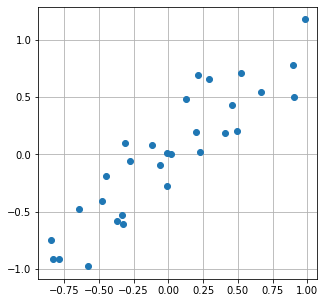

In [ ]:
data=load_sample_data_pca()

n_samples,n_dim=data.shape

print('We have ',n_samples, 'samples of dimension ', n_dim)

plt.figure(figsize=((5,5)))
plt.grid()
plt.plot(data[:,0],data[:,1],'o')
plt.show()

The data set is almost one dimensional. PCA will confirm this result.

As with most of sklearn functionalities, we need first to create a PCA object. We will use the object methods to perform PCA.

In [ ]:
pca=PCA(n_components=2) 

A call to the pca.fit method computes the principal components

In [ ]:
pca.fit(data)

PCA(n_components=2)

Now the pca.components_ attribute contains the principal components. We can print them alongside with the data and check that they constitute an orthonormal basis.

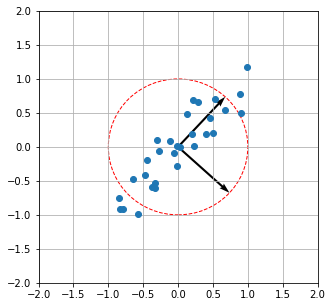

In [ ]:
plt.figure(figsize=((5,5)))
plt.grid()
plt.plot(data[:,0],data[:,1],'o')

circle=plt.Circle((0, 0), 1.0, linestyle='--', color='red',fill=False)
ax=plt.gca()
ax.add_artist(circle)

for vec in pca.components_:
    plt.quiver([0], [0], [vec[0]], [vec[1]], angles='xy', scale_units='xy', scale=1)

plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()

The pca.explained_variance_ratio_ attribute contains the explained variance. In this case we see that already the first reconstructed vector explains 95% of the variance.

In [ ]:
print(pca.explained_variance_ratio_)

[0.95140729 0.04859271]


To compute the reconstructed vectors for k=1 we first need to compute the scores and then multiply by the basis vectors:

$\mathbf x_{rec}=\sum_i (\mathbf x \cdot \mathbf v^{pr}_i) \mathbf v^{pr}_i$

In [ ]:
k=1
scores=pca.transform(data)
res=np.dot(scores[:,:k], pca.components_[:k,:] )

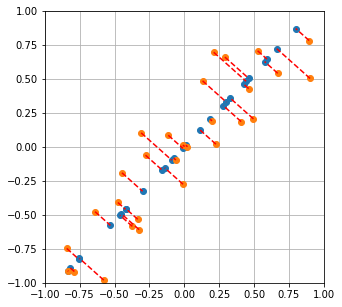

In [ ]:
plt.figure(figsize=((5,5)))
plt.plot(res[:,0],res[:,1],'o')
plt.plot(data[:,0],data[:,1],'o')

for a,b,c,d in zip(data[:,0],data[:,1],res[:,0],res[:,1]) :
    plt.plot([a,c],[b,d],'-', linestyle = '--', color='red')

plt.grid()

plt.xlim(-1.0,1.0)
plt.ylim(-1.0,1.0)
plt.show()

The same procedure is followed for high dimensional datasets. Here we generate random data which lies almost on a 6-dimensional subspace. The resulting scree plot can be used to find this result in a semi-automatic fashion.

In [ ]:
high_dim_dataset=load_multidimensional_data_pca(n_data=40 ,n_vec=6, dim=20, eps= 0.5)
n_samples,n_dim=high_dim_dataset.shape

print('We have ',n_samples, 'samples of dimension ', n_dim)
df = pd.DataFrame(high_dim_dataset)
df

We have  40 samples of dimension  20


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.355617,0.408945,-0.287654,0.516719,0.226601,1.485915,-0.380177,1.200225,0.046920,-0.866340,1.653442,1.292383,-0.297015,-1.234236,-0.813782,0.529801,0.756671,-1.809304,0.409510,0.108208
1,1.576700,0.652948,-0.546632,0.922386,-1.459629,-0.932953,0.244293,0.529858,-0.254544,1.537885,0.809287,-0.736717,-0.762950,-0.142773,-0.245108,-0.434467,-2.829758,-0.843078,0.546069,-1.247985
2,0.474602,-1.190126,1.515737,-1.356789,-0.935690,-1.181390,-1.438093,0.532499,1.433531,1.929001,-0.776199,-0.787098,0.553547,-0.040439,1.977151,-1.902341,-0.408846,1.494072,-0.224606,-0.412945
3,0.136939,-4.510213,0.335426,1.053868,-0.848840,0.709000,1.031204,1.535253,2.325713,-3.271504,-1.705949,3.399914,0.088586,-3.965057,-1.106875,-2.743819,1.878438,1.544598,-3.258186,-1.729235
4,0.605600,-0.627889,1.585616,-1.203416,-1.287271,-1.920005,-0.422972,-0.776442,1.709996,0.803650,-1.099803,0.251128,-1.836274,1.215547,0.499256,-0.795734,0.203805,1.789387,-0.912894,0.161455
5,-0.175479,3.279906,-3.530619,-0.113305,2.215248,1.057686,-0.434367,-1.661528,-3.187207,0.546758,0.520285,-3.693108,0.468814,0.389950,0.907320,2.150720,-0.146354,0.014570,0.456806,1.781756
6,0.512217,-0.802064,0.779109,2.394943,-1.382627,-2.691461,0.617815,-0.610589,-0.036251,0.957581,0.425000,2.731720,0.549224,-1.827622,-1.460532,-1.265866,0.414718,-0.449228,-1.309277,-2.711957
7,-0.307937,1.121183,1.710485,0.070186,1.031451,-0.338122,1.859982,-0.813495,-0.100030,-0.196730,-0.407228,3.671483,1.996359,-0.098105,-0.459957,0.495410,1.931314,-0.558930,-0.311584,-0.074517
8,-0.075775,0.969129,-0.538507,-2.228856,-0.595668,1.189082,-1.307494,1.436469,0.251810,-1.009029,-0.632045,-3.454481,-3.290508,2.726285,-0.562450,0.315738,-1.347090,0.582527,0.126186,2.706651
9,-0.760971,0.909549,-1.338492,0.402927,0.832736,1.518132,0.215777,-0.003186,-1.206407,-1.656175,-0.256934,0.011369,1.431586,-1.358848,-0.773533,1.314172,1.714778,-0.839920,-0.159241,-1.023819


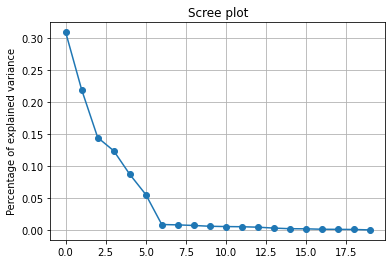

In [ ]:
pca=PCA()
pca.fit(high_dim_dataset)
plt.plot(pca.explained_variance_ratio_,'-o')
plt.title('Scree plot')
plt.ylabel('Percentage of explained variance')
plt.grid()
plt.show()

In [ ]:
print(pca.singular_values_)
df = pd.DataFrame(pca.singular_values_)
df

[24.49146053 20.62602652 16.75439472 15.51464217 13.01657909 10.40397969
  4.15785045  4.02823549  3.79364607  3.4655722   3.33020648  3.25587501
  3.03994887  2.54653152  2.14664975  2.06716889  1.72249331  1.63332306
  1.51022926  0.97551162]


,0
0,24.491461
1,20.626027
2,16.754395
3,15.514642
4,13.016579
5,10.403980
6,4.157850
7,4.028235
8,3.793646
9,3.465572


As an exercise, you can change the value of eps and see how the screen plot changes.

### EXERCISE 1 : Find the hidden drawing.

We have  961 samples of dimension  10
[0.79700994 0.15407412 0.00688753 0.00667879 0.00652795 0.00605738
 0.00596107 0.00576693 0.00561825 0.00541804]


Text(0, 0.5, 'Second component')

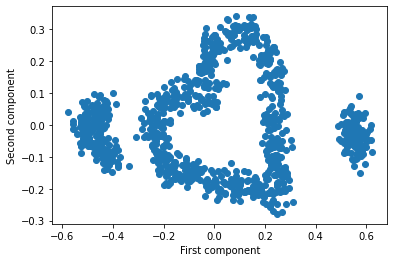

In [ ]:
data=load_ex2_data_pca(seed=1235)
n_samples,n_dim=data.shape
print('We have ',n_samples, 'samples of dimension ', n_dim)

pca=PCA()
pca.fit(data)

print(pca.explained_variance_ratio_)
#plt.plot(pca.explained_variance_ratio_)
#plt.show()

k=2
data_transformed=pca.transform(data)
plt.plot(data_transformed[:,0],data_transformed[:,1],'o')
plt.xlabel('First component')
plt.ylabel('Second component')

In [ ]:
### In this exercise you will take a high dimensional dataset, find the optimal number of principal components 
# and visualize the reconstructed vectors with k=2. The pipeline is the same as Ex. 2.

# 1. Load the data using the function data=load_ex2_data_pca(seed=1235) , check the dimensionality of the data and plot them.
data=load_ex2_data_pca(seed=1235)
n_samples,n_dim=... 
print('We have ',n_samples, 'samples of dimension ', n_dim)

# 2. Define a PCA object and perform the PCA fitting.
pca=PCA()
pca....(data)

# 3. Check the explained variance ratio and select best number of components.
print(pca...)
plt.plot(...)

# 4. Plot the reconstructed vectors for the best value of data=...
k=...
data_transformed=...
plt.plot(data_transformed[:,...],data_transformed[:,...],'o')
plt.xlabel('First component')
plt.ylabel('Second component')

SyntaxError: ignored

# Final comments:

PCA is able therefore to make this mapping:

$(x_1,...,x_D) \rightarrow (y_1,..,y_M)$

Here we focused on data compression, but it is also very important that $y_1,...,y_M$ are uncorrolated for interpratibility purposes. Being uncorrelated means (roughly) that in our dataset we can change one variable without affecting the others. The dimensions 1,...,M are often therefore more interpretable and providing more information.

See e.g. a similar application here:

"Principal component analysis of dietary and lifestyle patterns in relation to risk of subtypes of esophageal and gastric cancer", https://pubmed.ncbi.nlm.nih.gov/21435900/

, where each data point $x$ is an answer from a questionnaire of food. The principal components are than typical "patterns" of answers that are uncorrlated, have a look at table 2, and if you want read the whole data story :)

## 2. Data visualization and embedding in low dimensions ( t-SNE / UMAP )

### Theory overview

PCA is a linear embedding technique where the scores are a linear function of the original variables. This forces the number of principal components to be used to be high, if the manifold is highly non-linear. Curved manifolds need to be embedded in higher dimensions.

Other `non-linear` embedding techniques start from a local description of the environment of each sample point in the original space:

- `t-Sne` uses a `statistical description` of the environment of a sample point ;
- `UMAP` describes the `topology` of the environment through a generalized "triangulation" (simplex decomposition) ;

The projection on the low-dimensional space is optimized in order to match as much as possible the description of the local environment. 

It is not the goal of this introduction to discuss the derivation of such approaches, which can be found in the references:

https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf

https://arxiv.org/pdf/1802.03426.pdf



Instead, the following, we will show how to apply practically these dimensionality reductions techniques. Keep in mind that the embedding is given by an iterative solution of a minimization problem and therefore the results may depend on the value of the random seed, especially for t-SNE visualizazions.

### Utilization in Python and examples

To begin with, we create a t-SNE object that we are going to use.

In [ ]:
tsne_model = TSNE(perplexity=30, n_components=2, learning_rate=200, early_exaggeration=4.0,init='pca', 
                      n_iter=2000, random_state=2233212, metric='euclidean', verbose=100 )

umap_model = umap.UMAP(n_neighbors=30, n_components=2, random_state=1711)

### Example 1: Exercise 3 Cont'd

We will first visualize our multi-dimensional heart using t-SNE: 

In [ ]:
data= load_ex2_data_pca(seed=1235, n_add=20)

tsne_model = TSNE(perplexity=30, n_components=2, learning_rate=200, early_exaggeration=4.0,init='pca', 
                      n_iter=300, random_state=2233212, metric='euclidean', verbose=100 )

tsne_heart = tsne_model.fit_transform(data)

In [ ]:
plt.scatter(tsne_heart[:,0],tsne_heart[:,1])
plt.show()

And using UMAP :

In [ ]:
umap_model = umap.UMAP(n_neighbors=30, n_components=2, random_state=1711)

umap_hart = umap_model.fit_transform(data)
plt.scatter(umap_hart[:, 0], umap_hart[:, 1])
plt.show()

### Example 2: Mnist dataset

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

n_examples = 5000
data=train_images[:n_examples,:].reshape(n_examples,-1)
data=data/255

labels=train_labels[:n_examples]

In [ ]:
# not to run on COLAB

# tsne_model = TSNE(perplexity=10, n_components=2, learning_rate=200,
#                   early_exaggeration=4.0,init='pca', 
#                   n_iter=2000, random_state=2233212, 
#                   metric='euclidean', verbose=100, n_jobs=1)

# tsne_mnist = tsne_model.fit_transform(data)

# plt.scatter(tsne_mnist[:,0],tsne_mnist[:,1],c=labels,s=10)
# plt.show()

 | <img src="https://github.com/neworldemancer/DSF5/raw/master/figures/t_sne_mnist.png" width="100%"/> | <img src="https://github.com/neworldemancer/DSF5/raw/master/figures/mnist.png" width="100%"/> |
 |  -----:| -----:|

In [ ]:
umap_model = umap.UMAP(n_neighbors=10, n_components=2, random_state=1711)
umap_mnist = umap_model.fit_transform(data)
plt.scatter(umap_mnist[:, 0], umap_mnist[:, 1], c=labels, s=10)
plt.show()

### Example 3: Fashion_Mnist dataset

In [ ]:
fmnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fmnist.load_data()

n_examples = 5000
data=train_images[:n_examples,:].reshape(n_examples,-1)
data=data/255

labels=train_labels[:n_examples]

In [ ]:
# not to run on COLAB

# tsne_model = TSNE(perplexity=50, n_components=2, learning_rate=200, early_exaggeration=4.0,init='pca', 
#                      n_iter=1000, random_state=2233212, metric='euclidean', verbose=100 )

# tsne_fmnist = tsne_model.fit_transform(data)

# plt.scatter(tsne_fmnist[:,0],tsne_fmnist[:,1],c=labels,s=10)
# plt.show()

 | <img src="https://github.com/neworldemancer/DSF5/raw/master/figures/t_sne_fmnist.png" width="100%"/> | <img src="https://github.com/neworldemancer/DSF5/raw/master/figures/fmnist.png" width="100%"/> |
 |  -----:| -----:|

In [ ]:
umap_model = umap.UMAP(n_neighbors=50, n_components=2, random_state=1711)
umap_fmnist = umap_model.fit_transform(data)
plt.scatter(umap_fmnist[:, 0], umap_fmnist[:, 1], c=labels, s=10)
plt.show()

### Example 4: House prices

In [ ]:
data=house_prices_dataset_normed()

In [ ]:
# not to run on COLAB

#tsne_model = TSNE(perplexity=30, n_components=2, learning_rate=200,
#                  early_exaggeration=4.0,init='pca', n_iter=1000,
#                  random_state=2233212, metric='euclidean', verbose=100)

#tsne_houses = tsne_model.fit_transform(data)

#plt.scatter(tsne_houses[:,0],tsne_houses[:,1],s=20)
#plt.savefig('t_sne_houses.png')
# plt.show()

<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/t_sne_houses.png" width="50%"/>

In [ ]:
umap_model = umap.UMAP(n_neighbors=30, n_components=2, random_state=1711)
umap_houses = umap_model.fit_transform(data)
plt.scatter(umap_houses[:, 0], umap_houses[:, 1], s=20)
plt.show()

**Message:** Visualization techniques are useful for having an initial grasp of multi-dimensional datasets and guide further analysis and the choice of the modelling data strategy.

**Caveats:** 
- available t-SNE implementations may vary a lot in terms of performance. Computational time can be reduced performing PCA before a t-SNE projection

- UMAP, thanks to the algorithm being amanable to clever initializations and optimization schemes, offers great stability and scaling properties

- UMAP, even if starting from a local picture, is generally more able to spread apart different clusters

- The result of an embedding may depend on the values of the metaparameters. One should try to see how the final embedding changes in order to get to a complete picture